# Simulation of Vessel Trajectories & Anomalies

In [3]:
import logging
from datetime import datetime, timedelta
import json

from model import ShipModel
from agents.ship import Ship

logging.basicConfig(
    filename="notebook_logs.log",
    filemode="w",  # Overwrites on each run; use "a" to append
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

config_file="config/config.json"
with open(config_file) as f:
    config = json.load(f)

steps = config["simulation_steps"]
    
model = ShipModel(
        width=config["width"],
        height=config["height"],
        num_ships=config["num_ships"],
        max_speed_range=config["max_speed_range"],
        ports=config["ports"],
        speed_limit_zones=config.get("speed_limit_zones", []),
        obstacles=config["obstacles"],
        dwa_config=config["dwa_config"],
        resolution=config["resolution"],
        obstacle_threshold=config["obstacle_threshold"],
        lookahead=config["lookahead"]
    )

for type, agents in model.agents_by_type.items():
    print(f'{type}: {len(agents)}')

for ship in model.agents.select(agent_type=Ship):
    print(f"Ship {ship.unique_id} has a maximum speed of {ship.original_max_speed}.")

<class 'agents.obstacle.Obstacle'>: 8
<class 'agents.port.Port'>: 10
<class 'agents.ship.Ship'>: 100
Ship 19 has a maximum speed of 1.398186286246779.
Ship 20 has a maximum speed of 1.3297171878361873.
Ship 21 has a maximum speed of 1.3270962146372358.
Ship 22 has a maximum speed of 1.4637073601556925.
Ship 23 has a maximum speed of 1.4254120208843724.
Ship 24 has a maximum speed of 1.2187189393316094.
Ship 25 has a maximum speed of 1.0795817616214358.
Ship 26 has a maximum speed of 1.3153141813944933.
Ship 27 has a maximum speed of 1.072973490802662.
Ship 28 has a maximum speed of 1.487653854179183.
Ship 29 has a maximum speed of 1.1065922078296455.
Ship 30 has a maximum speed of 1.3432656483771377.
Ship 31 has a maximum speed of 1.1804291937299904.
Ship 32 has a maximum speed of 1.4493916983104684.
Ship 33 has a maximum speed of 1.0619297735092645.
Ship 34 has a maximum speed of 1.4171829234321218.
Ship 35 has a maximum speed of 1.3858549639460342.
Ship 36 has a maximum speed of 1.22

## Trajectory Simulation

In [4]:
print(f"{datetime.now()} Starting ...")
for t in range(steps):
    stride = 50
    if t%stride == 0:
        print(f"Steps {t} - {t+stride-1}...")
    model.step()
print(f"{datetime.now()} Finished.")

2025-04-02 10:41:51.945413 Starting ...
Steps 0 - 49...
Steps 50 - 99...
Steps 100 - 149...
Steps 150 - 199...
Steps 200 - 249...
Steps 250 - 299...
Steps 300 - 349...
Steps 350 - 399...
Steps 400 - 449...
Steps 450 - 499...
Steps 500 - 549...
Steps 550 - 599...
Steps 600 - 649...
Steps 650 - 699...
Steps 700 - 749...
Steps 750 - 799...
Steps 800 - 849...
Steps 850 - 899...
Steps 900 - 949...
Steps 950 - 999...
2025-04-02 11:07:12.294800 Finished.


In [5]:
agent_df = model.datacollector.get_agent_vars_dataframe().dropna()
df = agent_df.reset_index()
df

,Step,AgentID,x,y,AStarPath
0,0,19,10.000000,10.000000,"[(10, 10), (11, 10), (12, 10), (13, 10), (14, ..."
1,0,20,90.000000,10.000000,"[(90, 10), (89, 10), (88, 10), (87, 10), (86, ..."
2,0,21,45.000000,20.000000,"[(45, 20), (45, 21), (45, 22), (45, 23), (45, ..."
3,0,22,30.000000,50.000000,"[(30, 50), (31, 49), (32, 49), (33, 48), (34, ..."
4,0,23,55.000000,85.000000,"[(55, 85), (56, 84), (57, 83), (58, 82), (59, ..."
...,...,...,...,...,...
100095,1000,48,45.000000,20.000000,"[(10, 10), (11, 10), (12, 10), (13, 10), (14, ..."
100096,1000,53,16.000000,58.000000,"[(45, 20), (44, 21), (44, 22), (43, 23), (42, ..."
100097,1000,49,99.000000,35.000000,"[(55, 85), (56, 84), (57, 83), (58, 82), (59, ..."
100098,1000,97,70.000000,60.000000,"[(16, 58), (17, 58), (18, 58), (19, 58), (20, ..."


c:\Users\GraserA\Documents\GitHub\mesa\mesa\examples\basic\ships_hybrid_algorithm\visualization.py:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved simulation plot to simulation_plot.png


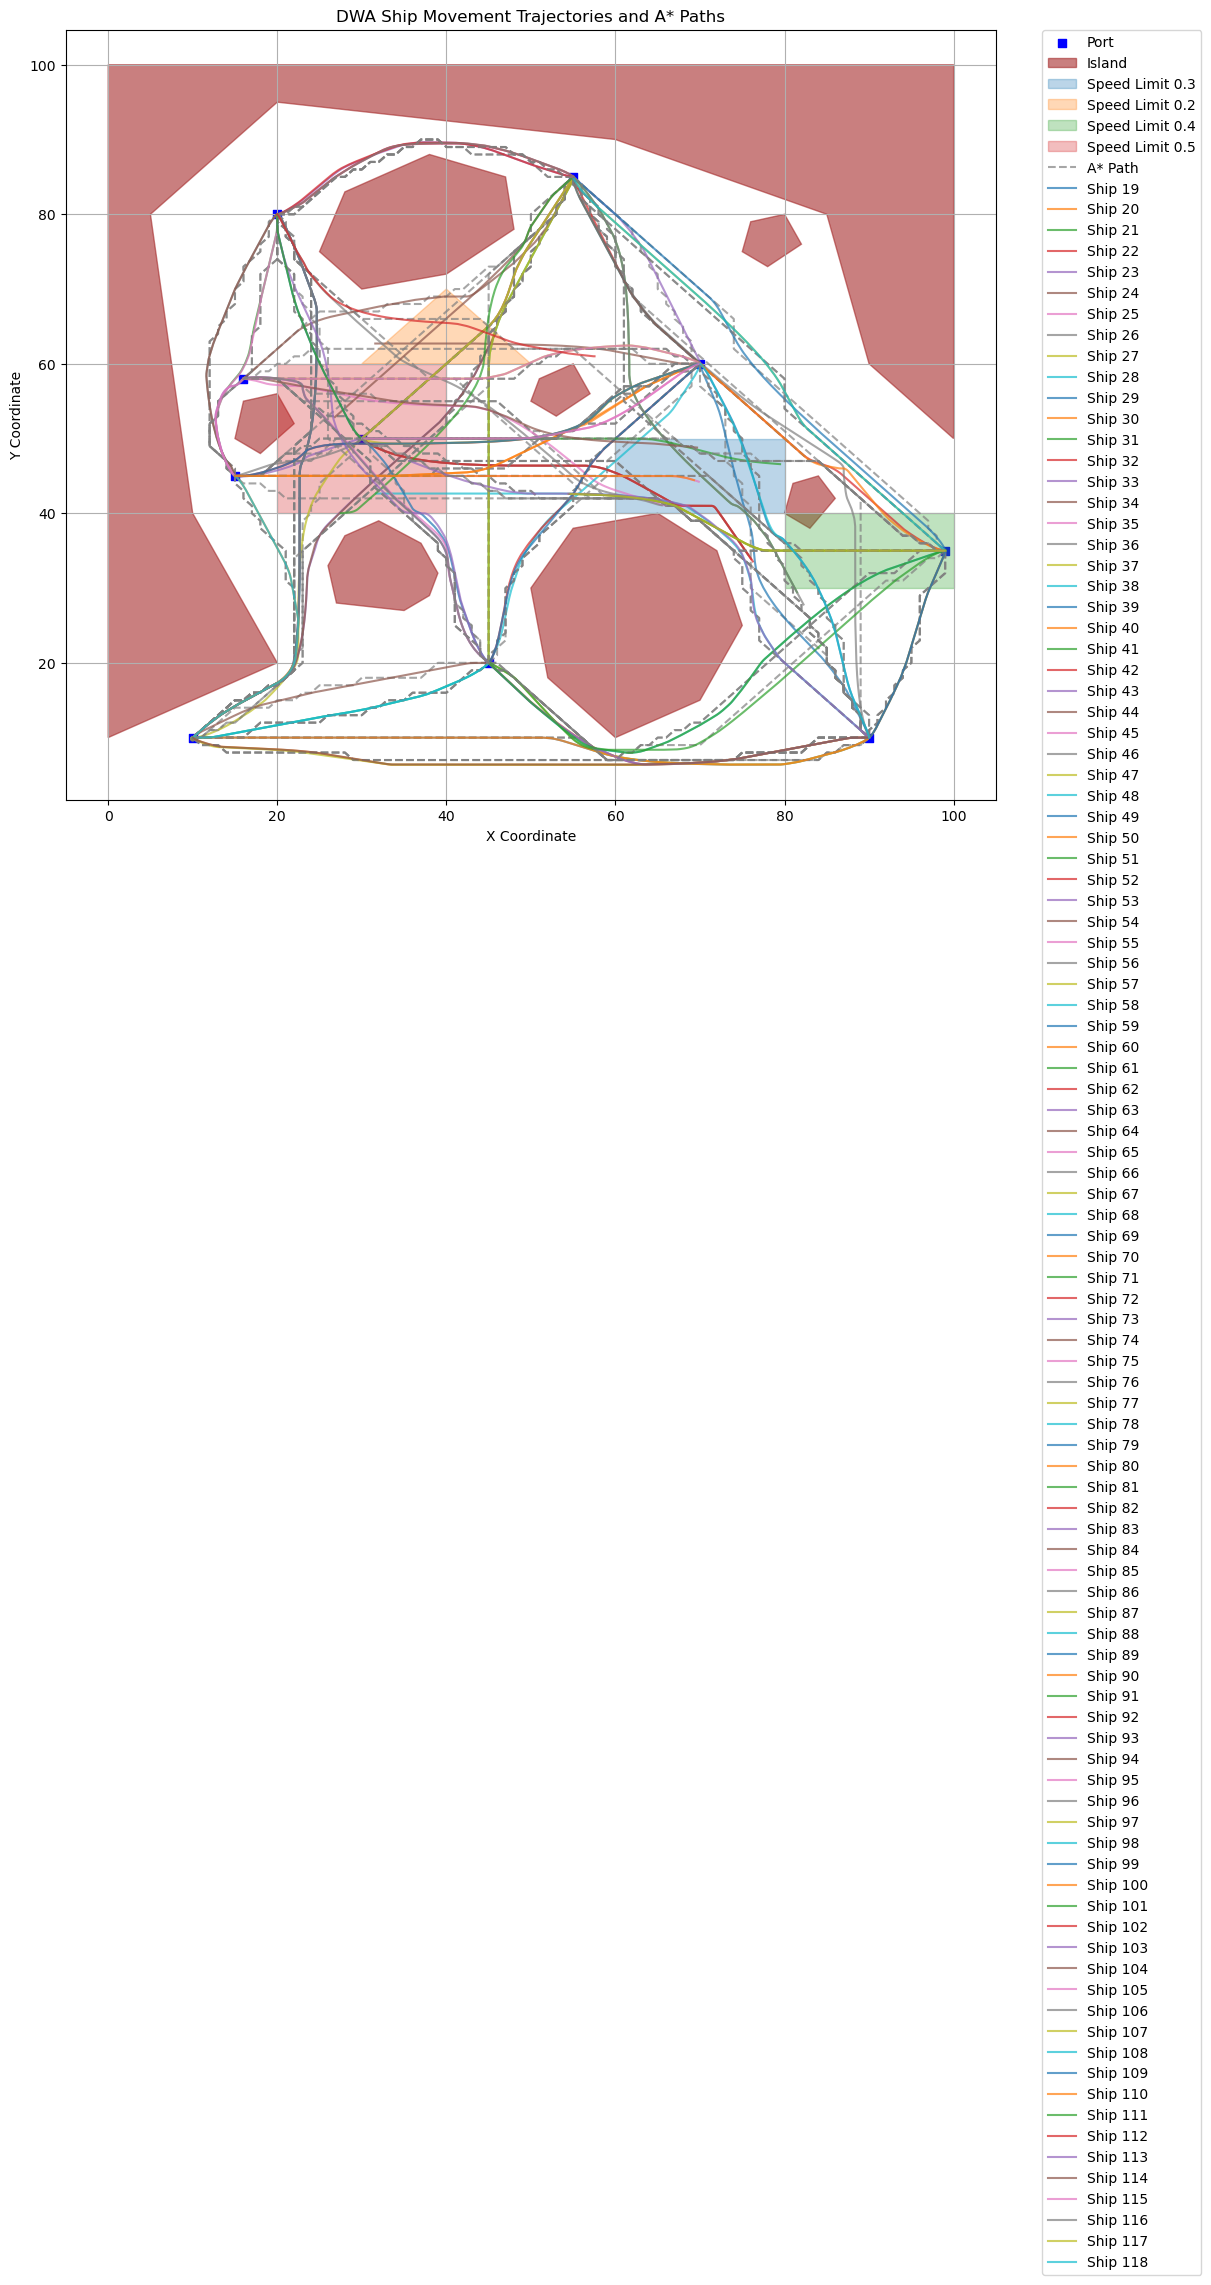

In [6]:
from visualization import plot_simulation

# Run visualization
plot_simulation(df, config)

In [7]:
import movingpandas as mpd

start_datetime = datetime.now()
df = df.drop('AStarPath', axis=1)
df["t"] = df["Step"].apply(lambda step: start_datetime + timedelta(seconds=step))
tc = mpd.TrajectoryCollection(df, traj_id_col='AgentID', t='t', x='x', y='y', crs=31287)

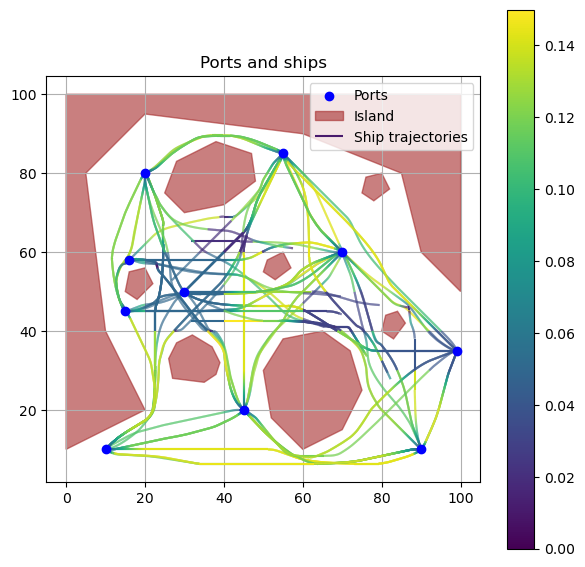

In [8]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

fig, ax = plt.subplots(figsize=(7,7))

x_coords, y_coords = zip(*config["ports"])
ax.scatter(x_coords, y_coords, color='blue', label='Ports', zorder=5)

for island in config["obstacles"]:
    island_shape = Polygon(island)
    x, y = island_shape.exterior.xy
    ax.fill(x, y, color="brown", alpha=0.6, label="Island" if 'Island' not in plt.gca().get_legend_handles_labels()[1] else "")

tc.plot(ax=ax, label='Ship trajectories', column='speed', legend=True)
ax.grid(True)

# Labels and legend
ax.legend()
ax.set_title("Ports and ships")

plt.show()

In [9]:
tc.trajectories[0].hvplot()

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (triangle_angle)

In [10]:
tc.add_speed(overwrite=True)
tc.trajectories[0].df#.hvplot(c='speed')

,Step,AgentID,geometry,speed
t,,,,
2025-04-02 11:08:11.666928,0,19,POINT (10 10),0.010
2025-04-02 11:08:12.666928,1,19,POINT (10.01 10),0.010
2025-04-02 11:08:13.666928,2,19,POINT (10.021 10),0.011
2025-04-02 11:08:14.666928,3,19,POINT (10.033 10),0.012
2025-04-02 11:08:15.666928,4,19,POINT (10.046 10),0.013
...,...,...,...,...
2025-04-02 11:24:47.666928,996,19,POINT (90 10),0.000
2025-04-02 11:24:48.666928,997,19,POINT (90 10),0.000
2025-04-02 11:24:49.666928,998,19,POINT (90 10),0.000


In [11]:
sim_result = tc.to_point_gdf()
sim_result['x'] = sim_result.geometry.x
sim_result['y'] = sim_result.geometry.y
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
sim_out_file_name = f'sim_{timestamp}.csv'
sim_result.to_csv(sim_out_file_name)
print(f'Saved simulation results to {sim_out_file_name}')
sim_result[sim_result['speed'] > 0.6]

Saved simulation results to sim_20250402_110955.csv


,Step,AgentID,geometry,speed,x,y
t,,,,,,


## Anomaly Simulation

In [77]:
import numpy as np
import pandas as pd
import movingpandas as mpd
from datetime import datetime, timedelta

In [78]:
sim_out_file_name = 'sim_20250402_110955.csv'

In [79]:
sims = pd.read_csv(sim_out_file_name)
#sims = sim_result

sims

,t,Step,AgentID,geometry,speed,x,y
0,2025-04-02 11:08:11.666928,0,19,POINT (10 10),0.010,10.000000,10.000000
1,2025-04-02 11:08:12.666928,1,19,POINT (10.01 10),0.010,10.010000,10.000000
2,2025-04-02 11:08:13.666928,2,19,POINT (10.020999999999999 10),0.011,10.021000,10.000000
3,2025-04-02 11:08:14.666928,3,19,POINT (10.033 10),0.012,10.033000,10.000000
4,2025-04-02 11:08:15.666928,4,19,POINT (10.046 10),0.013,10.046000,10.000000
...,...,...,...,...,...,...,...
100095,2025-04-02 11:24:47.666928,996,118,POINT (70.08658249212566 59.935181406824164),0.010,70.086582,59.935181
100096,2025-04-02 11:24:48.666928,997,118,POINT (70.07915104387088 59.94187271288775),0.010,70.079151,59.941873
100097,2025-04-02 11:24:49.666928,998,118,POINT (70.07154698421488 59.948367193371055),0.010,70.071547,59.948367
100098,2025-04-02 11:24:50.666928,999,118,POINT (70.06394292455887 59.95486167385436),0.010,70.063943,59.954862


In [80]:
sims.AgentID.unique()

array([ 19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118])

In [81]:
#sims = sims[sims.AgentID<29].copy()
sims['is_anomaly'] = False
sims['anomaly_type'] = 'n/a'
tc = mpd.TrajectoryCollection(sims, t='t', traj_id_col='AgentID', x='x', y='y', crs=31287)
tc

TrajectoryCollection with 100 trajectories

<Axes: >

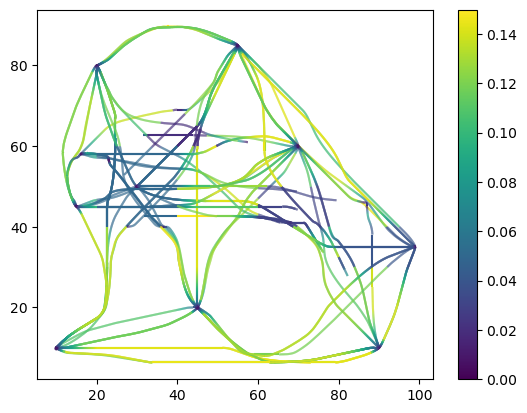

In [82]:
tc.add_speed(overwrite=True)
tc.plot(column='speed', legend=True)

In [83]:
# Remove stopped segments (with speed < 0.01)
tc = mpd.SpeedSplitter(tc).split(speed=0.01, duration=timedelta(seconds=5))

### Speed

Change the timestamps to make a subsection of the trajectory faster

In [84]:
def inject_speed_anomaly(traj, duration_pct=(0.1,0.2), speedup_pct=(1.5,2.5)):
    df = traj.df.copy()
    df.reset_index(inplace=True)
    df["t_diff"] = df['t'].diff()
    # Choose within middle range
    total_steps = len(df)
    anomaly_start_idx = np.random.randint(0.1 * total_steps, 0.8 * total_steps)  
    duration_pct = duration_pct[0] + (np.random.random() * (duration_pct[1]-duration_pct[0]))
    anomaly_duration = int(duration_pct * total_steps)  
    # Insert new values
    speedup_pct = speedup_pct[0] + (np.random.random() * (speedup_pct[1]-speedup_pct[0]))
    new_vals = df.iloc[anomaly_start_idx : anomaly_start_idx + anomaly_duration].t_diff / speedup_pct
    df.loc[anomaly_start_idx : anomaly_start_idx + anomaly_duration -1, "t_diff"] = new_vals
    # Flag anomalies
    df.loc[anomaly_start_idx : anomaly_start_idx + anomaly_duration -1, "is_anomaly"] = True
    df.loc[anomaly_start_idx : anomaly_start_idx + anomaly_duration -1, "anomaly_type"] = 'speed'

    # Correct the timestamp update logic
    df["t"] = df["t"].iloc[0] + df["t_diff"].fillna(pd.Timedelta(seconds=0)).cumsum()
    return mpd.Trajectory(df,t='t',traj_id=traj.id)

<Axes: >

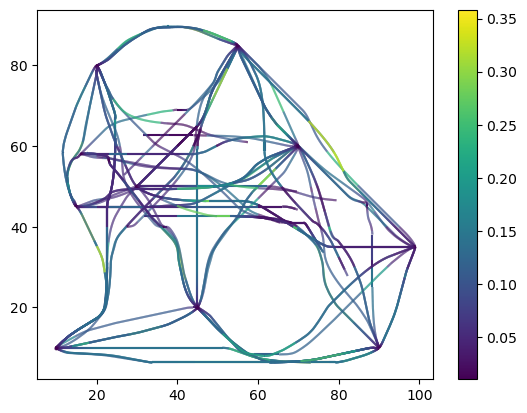

In [85]:
for i, traj in enumerate(tc.trajectories):
    traj = inject_speed_anomaly(traj)
    tc.trajectories[i] = traj
    
tc.add_speed(overwrite=True)
tc.plot(column='speed', legend=True)

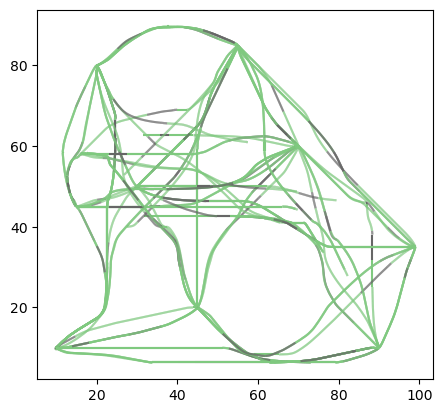

In [86]:
ax = tc.plot(column='is_anomaly', cmap='Accent')

In [38]:
tc.trajectories[5].hvplot(c='speed')

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]   (speed)
   .Points.I :Points   [Longitude,Latitude]   (speed,triangle_angle)

In [87]:
sim_result = tc.to_point_gdf()
sim_result['x'] = sim_result.geometry.x
sim_result['y'] = sim_result.geometry.y
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
sim_out_file_name = f'anomalies_speed_{timestamp}.csv'
sim_result.to_csv(sim_out_file_name)
print(f'Saved simulated speed anomalies to {sim_out_file_name}')

Saved simulated speed anomalies to anomalies_speed_20250402_134020.csv


### Location

#### Generate trajectories that pass through obstacles

In [41]:
import logging
from datetime import datetime, timedelta
import json

from model import ShipModel
from agents.ship import Ship

logging.basicConfig(
    filename="notebook_logs.log",
    filemode="w",  # Overwrites on each run; use "a" to append
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

config_file="config/config.json"
with open(config_file) as f:
    config = json.load(f)

steps = config["simulation_steps"]
    
model = ShipModel(
        width=config["width"],
        height=config["height"],
        num_ships=config["num_ships"],
        max_speed_range=config["max_speed_range"],
        ports=config["ports"],
        speed_limit_zones=config.get("speed_limit_zones", []),
        obstacles=[config["obstacles"][0]], # Here we only select the first obstacle that describes the main land mass
        dwa_config=config["dwa_config"],
        resolution=config["resolution"],
        obstacle_threshold=config["obstacle_threshold"],
        lookahead=config["lookahead"]
    )

In [42]:
print(f"{datetime.now()} Starting ...")
for t in range(steps):
    stride = 50
    if t%stride == 0:
        print(f"Steps {t} - {t+stride-1}...")
    model.step()
print(f"{datetime.now()} Finished.")

2025-04-02 12:29:43.510287 Starting ...
Steps 0 - 49...
Steps 50 - 99...
Steps 100 - 149...
Steps 150 - 199...
Steps 200 - 249...
Steps 250 - 299...
Steps 300 - 349...
Steps 350 - 399...
Steps 400 - 449...
Steps 450 - 499...
Steps 500 - 549...
Steps 550 - 599...
Steps 600 - 649...
Steps 650 - 699...
Steps 700 - 749...
Steps 750 - 799...
Steps 800 - 849...
Steps 850 - 899...
Steps 900 - 949...
Steps 950 - 999...
2025-04-02 12:55:46.305234 Finished.


In [91]:
agent_df = model.datacollector.get_agent_vars_dataframe().dropna()
df = agent_df.reset_index()
df

,Step,AgentID,x,y,AStarPath
0,0,12,30.00000,50.000000,"[(30, 50), (29, 51), (28, 51), (27, 52), (26, ..."
1,0,13,70.00000,60.000000,"[(70, 60), (69, 59), (68, 58), (67, 57), (66, ..."
2,0,14,16.00000,58.000000,"[(16, 58), (17, 59), (18, 60), (19, 61), (20, ..."
3,0,15,20.00000,80.000000,"[(20, 80), (20, 79), (20, 78), (20, 77), (20, ..."
4,0,16,15.00000,45.000000,"[(15, 45), (15, 46), (15, 47), (15, 48), (15, ..."
...,...,...,...,...,...
100095,1000,28,55.00000,85.000000,"[(16, 58), (17, 59), (18, 60), (19, 61), (20, ..."
100096,1000,104,20.00000,80.000000,"[(16, 58), (16, 59), (16, 60), (16, 61), (16, ..."
100097,1000,15,16.00000,58.000000,"[(20, 80), (20, 79), (20, 78), (20, 77), (20, ..."
100098,1000,98,55.00000,85.000000,"[(70, 60), (69, 61), (68, 62), (67, 63), (66, ..."


c:\Users\GraserA\Documents\GitHub\mesa\mesa\examples\basic\ships_hybrid_algorithm\visualization.py:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved simulation plot to simulation_plot.png


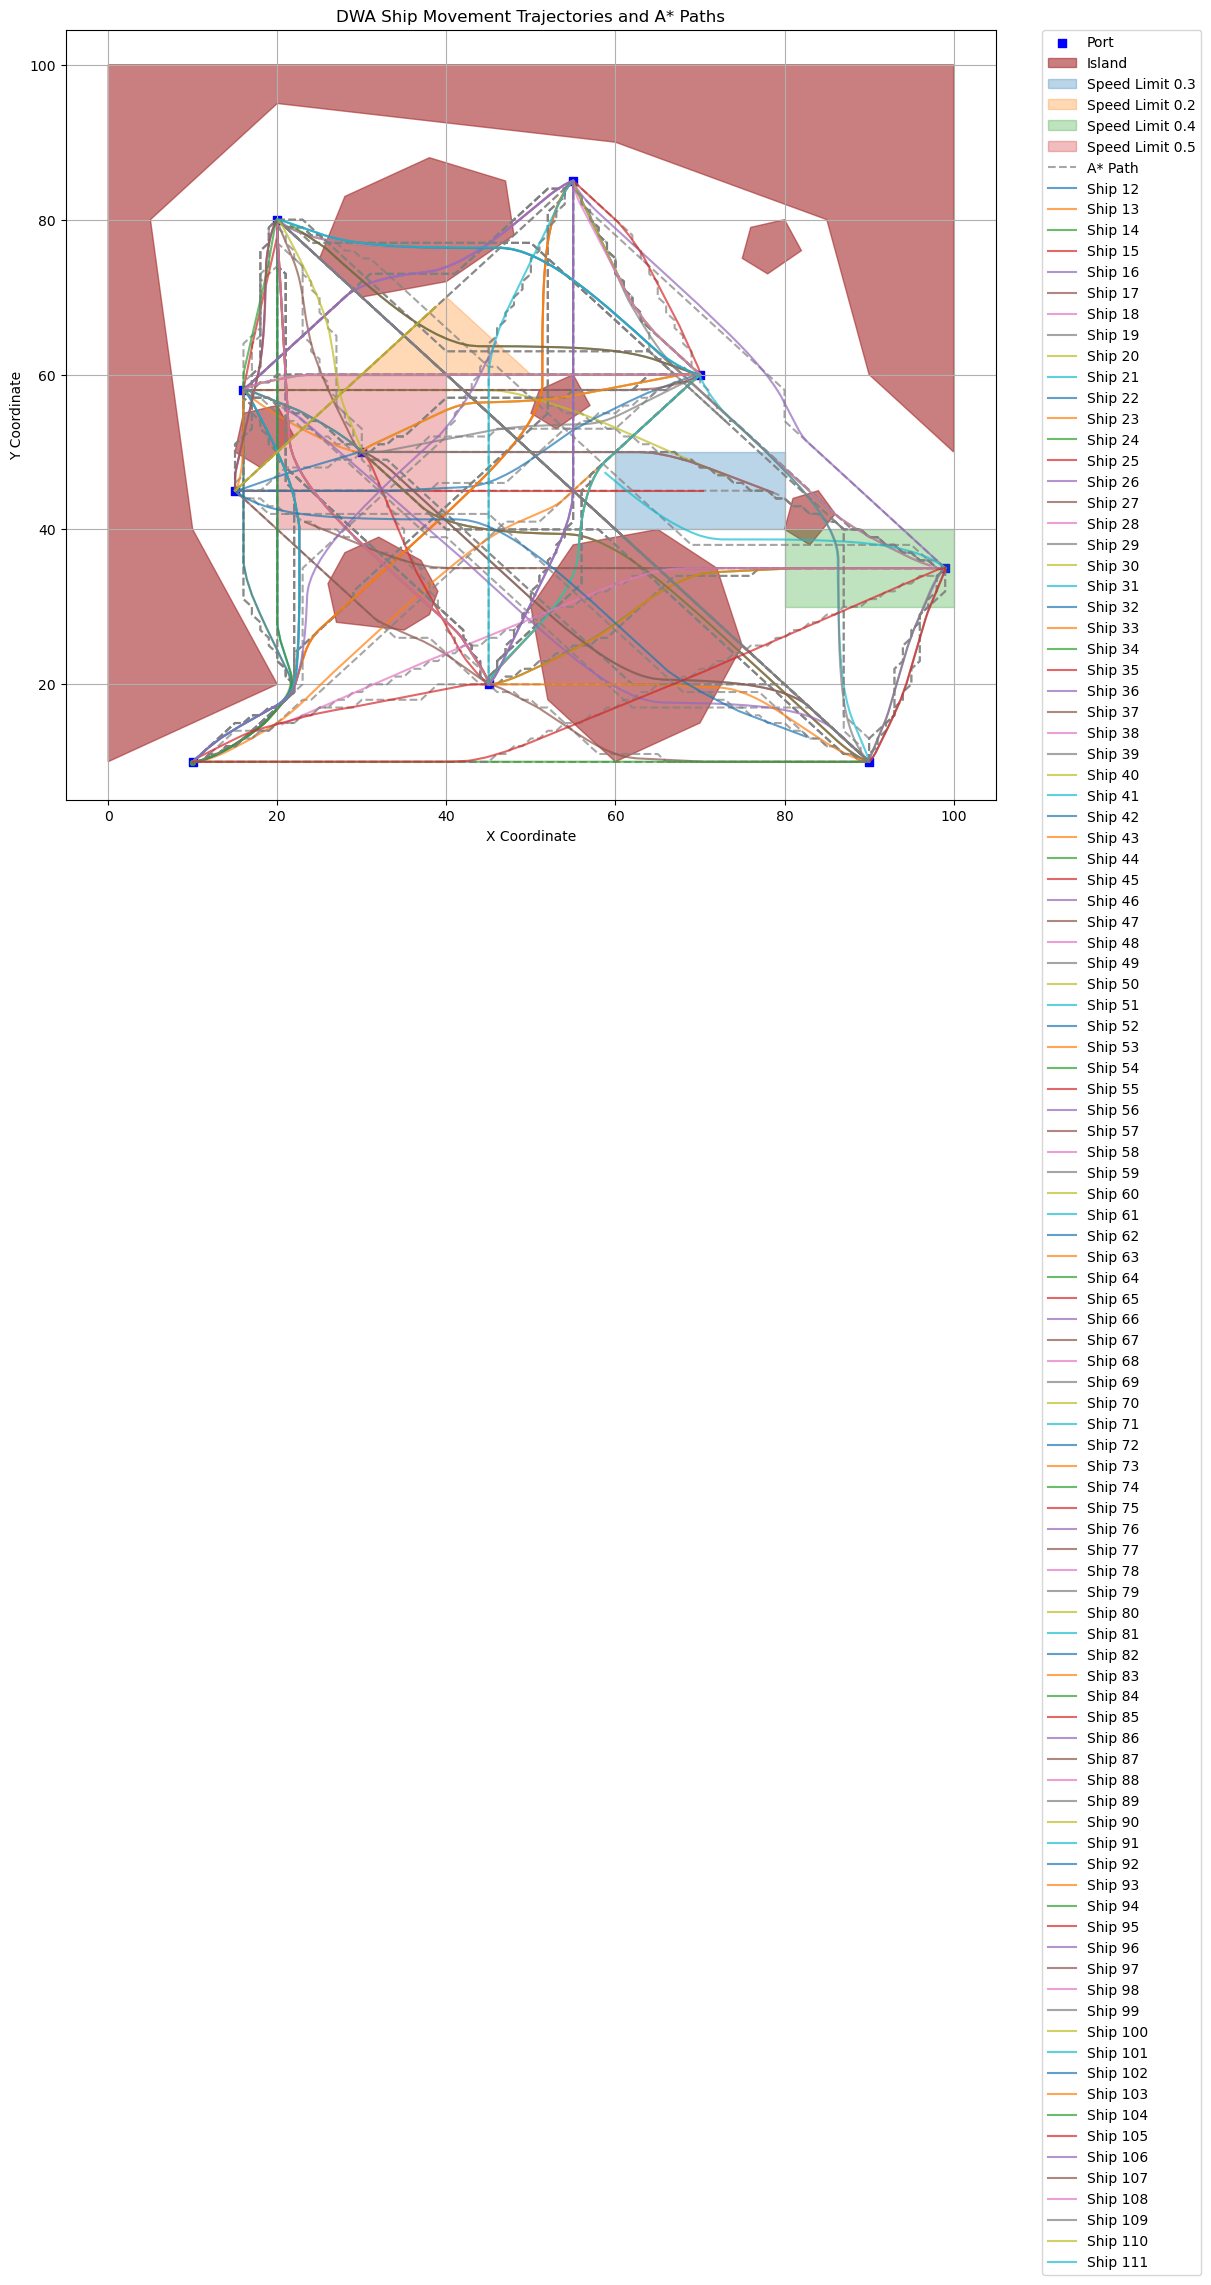

In [92]:
from visualization import plot_simulation
plot_simulation(df, config)

In [93]:
import movingpandas as mpd

start_datetime = datetime.now()
df = df.drop('AStarPath', axis=1)
df["t"] = df["Step"].apply(lambda step: start_datetime + timedelta(seconds=step))
tc = mpd.TrajectoryCollection(df, traj_id_col='AgentID', t='t', x='x', y='y', crs=31287)

In [94]:
tc.add_speed(overwrite=True)
tc.trajectories[0].df

,Step,AgentID,geometry,speed
t,,,,
2025-04-02 13:41:58.487606,0,12,POINT (30 50),0.010
2025-04-02 13:41:59.487606,1,12,POINT (29.993 50.007),0.010
2025-04-02 13:42:00.487606,2,12,POINT (29.985 50.015),0.011
2025-04-02 13:42:01.487606,3,12,POINT (29.977 50.023),0.012
2025-04-02 13:42:02.487606,4,12,POINT (29.967 50.033),0.013
...,...,...,...,...
2025-04-02 13:58:34.487606,996,12,POINT (16 58),0.000
2025-04-02 13:58:35.487606,997,12,POINT (16 58),0.000
2025-04-02 13:58:36.487606,998,12,POINT (16 58),0.000


In [95]:
sim_result = tc.to_point_gdf()
sim_result['x'] = sim_result.geometry.x
sim_result['y'] = sim_result.geometry.y
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
sim_out_file_name = f'sim_no-obstacles_{timestamp}.csv'
sim_result.to_csv(sim_out_file_name)
print(f'Saved simulation results to {sim_out_file_name}')

Saved simulation results to sim_no-obstacles_20250402_134206.csv


#### Flag anomalies

In [96]:
sims = pd.read_csv(sim_out_file_name)
sims

,t,Step,AgentID,geometry,speed,x,y
0,2025-04-02 13:41:58.487606,0,12,POINT (30 50),0.010,30.000000,50.000000
1,2025-04-02 13:41:59.487606,1,12,POINT (29.992928932188136 50.007071067811864),0.010,29.992929,50.007071
2,2025-04-02 13:42:00.487606,2,12,POINT (29.985150757595083 50.014849242404914),0.011,29.985151,50.014849
3,2025-04-02 13:42:01.487606,3,12,POINT (29.976665476220845 50.023334523779155),0.012,29.976665,50.023335
4,2025-04-02 13:42:02.487606,4,12,POINT (29.967473088065418 50.03252691193458),0.013,29.967473,50.032527
...,...,...,...,...,...,...,...
100095,2025-04-02 13:58:34.487606,996,111,POINT (70 60),0.000,70.000000,60.000000
100096,2025-04-02 13:58:35.487606,997,111,POINT (70 60),0.000,70.000000,60.000000
100097,2025-04-02 13:58:36.487606,998,111,POINT (70 60),0.000,70.000000,60.000000
100098,2025-04-02 13:58:37.487606,999,111,POINT (70 60),0.000,70.000000,60.000000


In [97]:
#sims = sims[sims.AgentID<22].copy()
sims['is_anomaly'] = False
sims['anomaly_type'] = 'n/a'
tc = mpd.TrajectoryCollection(sims, t='t', traj_id_col='AgentID', x='x', y='y', crs=31287)
tc

TrajectoryCollection with 100 trajectories

<Axes: >

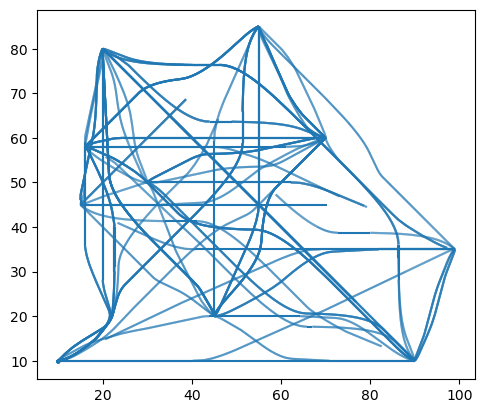

In [98]:
tc.plot()

In [99]:
from shapely.geometry import Polygon
from geopandas import GeoSeries

def inject_location_anomaly(traj, polygon):
    df = traj.df.copy()
    intersecting = df.intersects(polygon)
    df.loc[intersecting, 'is_anomaly'] = True
    df.loc[intersecting, 'anomaly_type'] = 'location'
    return mpd.Trajectory(df,t='t',traj_id=traj.id)

In [100]:

obstacles=config["obstacles"]
polygons=[]

for obstacle in obstacles:
    polygon = Polygon(obstacle)
    polygons.append(polygon)
    for i, traj in enumerate(tc.trajectories):
        traj = inject_location_anomaly(traj, polygon)
        tc.trajectories[i] = traj
    

<Axes: >

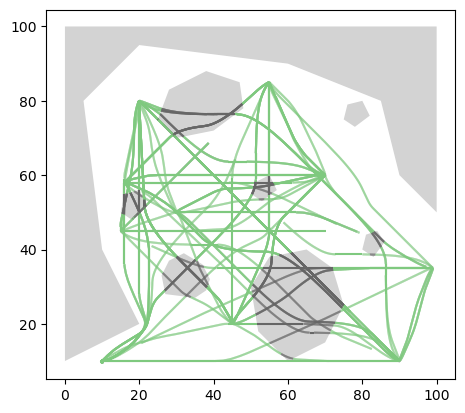

In [101]:
ax = tc.plot(column='is_anomaly', cmap='Accent')
GeoSeries(polygons).plot(ax=ax, color="lightgray")

In [102]:
sim_result = tc.to_point_gdf()
sim_result['x'] = sim_result.geometry.x
sim_result['y'] = sim_result.geometry.y
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
sim_out_file_name = f'anomalies_loc_{timestamp}.csv'
sim_result.to_csv(sim_out_file_name)
print(f'Saved simulated location anomalies to {sim_out_file_name}')

Saved simulated location anomalies to anomalies_loc_20250402_134236.csv


### Direction

TODO